# Logistic Regression with IRLS implementation

* Implement 10 fold cross validation
* ROC AUC Plot

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler

## 1. Import IRIS data

In [2]:
raw_df = pd.read_csv('data/iris.csv')

In [3]:
iris_df = raw_df[raw_df['variety']!='Setosa']

In [4]:
scaler = MinMaxScaler()

In [5]:
X = iris_df.iloc[:,:-1]
y = iris_df.variety
y= y.map({'Versicolor':1,'Virginica':0})

In [6]:
len(y)

100

In [7]:
X = scaler.fit_transform(X)

In [8]:
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,shuffle=True)

In [9]:
train_X.shape

(80, 4)

In [20]:
class LogisticRegression:
    def __init__(self,plot=True):
        self.plot_loss = plot
        pass
    def fit(self,X,y):
        self.train_X = self.transform_X(X)
        self.train_y = self.transform_y(y)
        self.N,self.D = self.train_X.shape
        print(f"Shape of train_X:{self.train_X.shape}")
        self.optimize(plot=self.plot_loss)
        
    def optimize(self,plot,epoch=10):
        betas = np.zeros((self.D,1))
        losses =[]
        for e in range(epoch):
            # I will follow Bishop notation
            y = self.sigmoid(np.matmul(self.train_X,betas))
            R = np.diag(np.ravel(y*(1-y)))
            grad = np.matmul(self.train_X.T,(y-self.train_y))
            hessian = np.matmul(np.matmul(self.train_X.T,R),self.train_X)+0.001*np.eye(self.D)
            betas -= np.matmul(inv(hessian),grad)
            loss = self.cross_entropy_loss(self.train_y,self.sigmoid(np.matmul(self.train_X,betas)))
            losses.append(loss)
        self.coef = betas[1:]
        self.intercept = betas[0]
        if plot:
            plt.title('Loss Curve')
            plt.xlabel('Update round')
            plt.ylabel('Loss')
            plt.plot(losses)
        
    
    def predict(self,test_X, thres=0.5):
        test_X = np.array(test_X)
        pred_y= self.sigmoid(np.matmul(test_X,self.coef)+self.intercept)
        return np.where(pred_y > thres, 1, 0)
        
    def predict_proba(self,test_X):
        test_X = np.array(test_X)
        return self.sigmoid(np.matmul(test_X,self.coef)+self.intercept)
    
    def transform_X(self,X):
        X = np.array(X)
        X = np.insert(X,0,np.ones((X.shape[0])),axis=1)
        return X
    def transform_y(self,y):
        y = np.array(y)
        y = y.reshape((y.shape[0],-1))
        return y
    
    def cross_entropy_loss(self,y_true,y_pred,clip_val=1e-10):
        y_pred = np.clip(y_pred,clip_val,1-clip_val)
        loss = np.multiply(y_true,np.log(y_pred))
        total_loss = -np.sum(loss,axis=0)
        return total_loss
        
    def sigmoid(self,x):
        return 1 / (1 +np.exp(-x))
        

Shape of train_X:(80, 5)


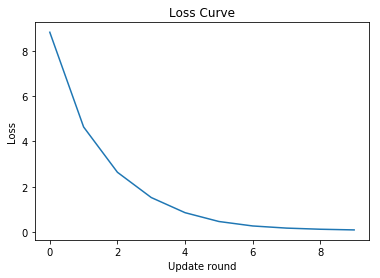

In [21]:
LR_model = LogisticRegression()
LR_model.fit(train_X,train_y)

## 2. 10 Fold Cross Validation from scratch

In [12]:
class PerformanceMeasure:
    def __init__(self,predict_y,test_y):
        self.predict_y = predict_y
        self.test_y = test_y
        self.calculate_confusion_matrix()
        
    def calculate_confusion_matrix(self):
        self.tp = sum((self.predict_y==1)&(self.test_y==1))
        self.tn = sum((self.predict_y==0)&(self.test_y==0))
        self.fn = sum((self.predict_y==0)&(self.test_y==1))
        self.fp = sum((self.predict_y==1)&(self.test_y==0))
    def accuracy(self,eps =0.001):
        self.accuracy= (self.tp+self.tn)/(len(self.test_y)+eps)
        return self.accuracy
    def sensitivity(self,eps=0.001):
        self.sensitivity= (self.tp)/(self.tp+self.fn+eps)

        return self.sensitivity
    def specificity(self,eps=0.001):
        self.specificity = (self.tn)/(self.tn+self.fp+eps)
        return self.specificity
    def false_positive_rate(self):
        return (self.fp)/(self.tn+self.fp)
    
    def print_confusion(self):
        print('='*40)
        print('CONFUSION MATRIX')
        print(f'TP:{self.tp}, FN:{self.fn}')
        print(f'FP:{self.fp}, FP:{self.tn}')
        print('='*40)
            
        #https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        

In [13]:
class kfold:
    def __init__(self,K,X,y):
        self.K = K
        self.X = np.array(X)
        self.y = np.array(y)
        self.shuffle()
        self.total_samples =len(X)
        self.split()

        
    def split(self):
        self.split_data_X = np.array_split(self.X,self.K)
        self.split_data_y = np.array_split(self.y,self.K)

    def shuffle(self):
        s = np.arange(self.X.shape[0])
        np.random.shuffle(s)
        self.X = self.X[s]
        self.y = self.y[s]
        
    def run(self,model):
        score_dict= defaultdict(list)
        for i in range(self.K):
            total_data_X = self.split_data_X.copy()
            total_data_y = self.split_data_y.copy()
            
            
            test_X = total_data_X[i].copy()
            test_y = total_data_y[i].copy()
            del total_data_X[i],total_data_y[i]
            
            
            train_X = np.concatenate(total_data_X[:])
            train_y = np.concatenate(total_data_y[:])
            model.fit(train_X,train_y)
            
            predict_y_proba = model.predict_proba(test_X)
            predict_y = model.predict(test_X)
            measure = PerformanceMeasure(np.squeeze(predict_y),np.squeeze(test_y))
            
            accuracy = measure.accuracy()
            sensitivity = measure.sensitivity()
            specificity = measure.specificity()
            
            score_dict['accuracy'].append(accuracy)
            score_dict['sensitivity'].append(sensitivity)
            score_dict['specificity'].append(specificity)
        print('='*50)
        print(f"With {self.K}-fold the scores are as below")
        print(f"Accuracy: {np.mean(score_dict['accuracy'])}")
        print(f"Sensitivity: {np.mean(score_dict['sensitivity'])}")
        print(f"Specificity: {np.mean(score_dict['specificity'])}")  
        print('='*50)

In [14]:
fold = kfold(10,X,y)

With 10-fold the scores are as below
Accuracy: 0.9499050094990503
Sensitivity: 0.9655008544606127
Specificity: 0.956927128910927


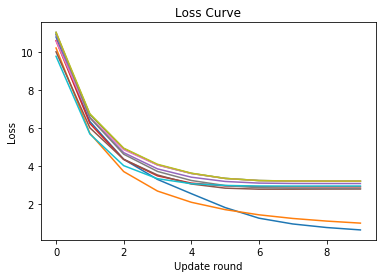

In [15]:
fold.run(LR_model)
plt.savefig('fig/Loss_Curve.png',dpi=300)

## 3. One time estimation
* train : 70% test: 30%

In [20]:
def roc_auc(model,test_X,test_y):
    tprs =[]
    fprs =[]
    threshold = [0.002 * i for i in range(500)]
    
    roc_points =[]
    for thres in threshold:
        predict_y = model.predict(test_X,thres=thres)
        measure = PerformanceMeasure(np.squeeze(predict_y),np.squeeze(test_y))
        sensitivity = measure.sensitivity()
        fpr = measure.false_positive_rate()
        tprs.append(sensitivity)
        fprs.append(fpr)
    tprs.append(0)
    fprs.append(0)
    plt.plot(fprs,tprs, 'y', lw=2)
    plt.plot([0, 1], [0, 1], 'k-', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    

In [21]:
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=9)

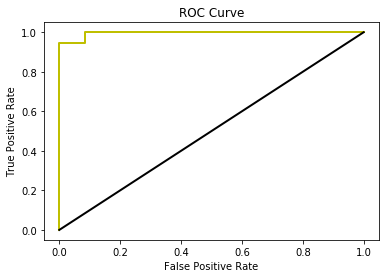

In [22]:
LR = LogisticRegression(False)
LR.fit(train_X,train_y)
roc_auc(LR,test_X,test_y)
plt.savefig('fig/ROC-AUC.png',dpi=300)

In [23]:
predict_y = LR.predict(test_X)
measure = PerformanceMeasure(np.squeeze(predict_y),np.squeeze(test_y))

In [24]:
measure.print_confusion()

CONFUSION MATRIX
TP:18, FN:0
FP:1, FP:11


In [25]:
specificity = measure.specificity()
sensitivity = measure.sensitivity()
accuracy = measure.accuracy()

In [26]:
print('ACCURACY:', accuracy)
print('SPECIFICITY:',specificity)
print('SENSITIVITY:',sensitivity)

ACCURACY: 0.9666344455184827
SPECIFICITY: 0.9165902841429882
SENSITIVITY: 0.9999444475306927
